# Trabajo Final Lenguajes 2025
Autor: **Alberto Boratti, Braian Ayala**

## 1. Carga de datos y exploración inicial
En esta sección cargamos los datasets principales (movies y credits),
que contienen información de películas, presupuesto, recaudación,
reparto y equipo técnico. También hacemos la importación de librerías 
necesarias para el análisis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import ast
import json

# Cargamos los datasets principales
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

## 2. Limpieza y preparación
Convertimos fechas, extraemos el año, calculamos ROI y procesamos los géneros
para poder analizarlos correctamente. También unimos las tablas de movies
y credits para tener toda la información consolidada.

In [2]:
# Convertimos fechas a formato datetime y extraemos el año
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year

# Calculamos ROI evitando divisiones por cero
movies['roi'] = np.where(movies['budget'] > 0, movies['revenue'] / movies['budget'], np.nan)


In [3]:
# Función robusta para parsear géneros desde JSON/string/lista
def parse_genres(x):
    # Caso 1: ya es lista
    if isinstance(x, list):
        return [g.get("name") for g in x if isinstance(g, dict)]
    
    # Caso 2: es string
    if isinstance(x, str):
        try:
            data = json.loads(x)   # json.loads es más estable que literal_eval
            return [g.get("name") for g in data if isinstance(g, dict)]
        except:
            return []
    
    # Caso 3: cualquier otra cosa (NaN, None)
    return []

# Expandimos cada película en múltiples filas, una por género
movies['genres_list'] = movies['genres'].apply(parse_genres)
movies_exploded = movies.explode('genres_list')


In [4]:
# Unimos los datasets de películas y créditos
df = movies.merge(credits, left_on='id', right_on='movie_id', how='left')
df.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title_x,vote_average,vote_count,year,roi,genres_list,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Avatar,7.2,11800,2009.0,11.763566,"[Action, Adventure, Fantasy, Science Fiction]",19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Pirates of the Caribbean: At World's End,6.9,4500,2007.0,3.203333,"[Adventure, Fantasy, Action]",285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Spectre,6.3,4466,2015.0,3.594590,"[Action, Adventure, Crime]",206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,The Dark Knight Rises,7.6,9106,2012.0,4.339756,"[Action, Crime, Drama, Thriller]",49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,John Carter,6.1,2124,2012.0,1.092843,"[Action, Adventure, Science Fiction]",49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## 3. Eje 1: Rentabilidad (ROI) por género
Calculamos el ROI por género, tomando solo películas con datos válidos
(budget y revenue mayores a cero). Luego generamos un ranking de los géneros
más rentables y lo visualizamos en un gráfico de barras.

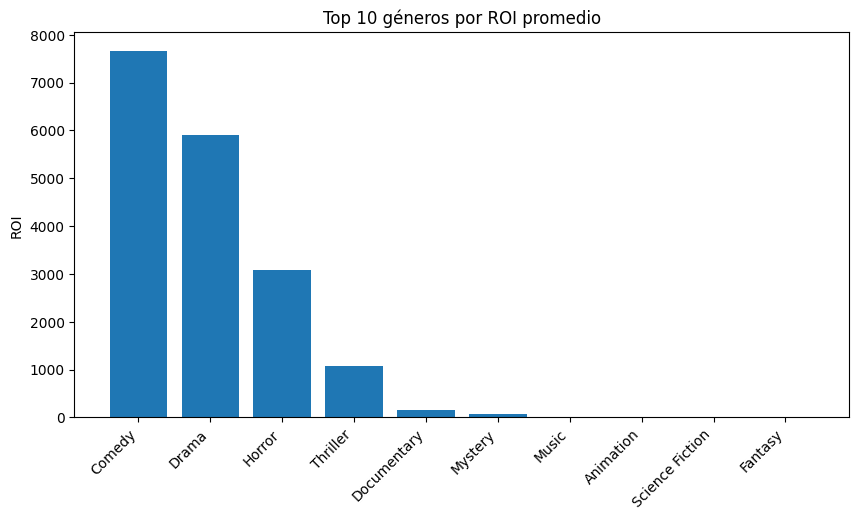

In [5]:
valid = movies_exploded[(movies_exploded['budget']>0)&(movies_exploded['revenue']>0)].copy()
valid['roi'] = valid['revenue']/valid['budget']

# Crear DataFrame limpio
roi_gen_df = (
    valid.groupby('genres_list')['roi']
         .mean()
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={'genres_list':'genre', 'roi':'roi'})
)

# Gráfico
plt.figure(figsize=(10,5)) 
plt.bar(roi_gen_df['genre'].head(10), roi_gen_df['roi'].head(10))
plt.title('Top 10 géneros por ROI promedio')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.show()


In [6]:
# Guardar resultados en CSV
roi_gen_df.to_csv('roi_por_genero.csv', index=False)

## 4. Eje 2: Relación entre presupuesto y rating
Analizamos si existe relación entre el presupuesto de una película y su rating.
Se genera un dispersograma (budget vs rating) y se aplica escala logarítmica 
para visualizar mejor los datos.

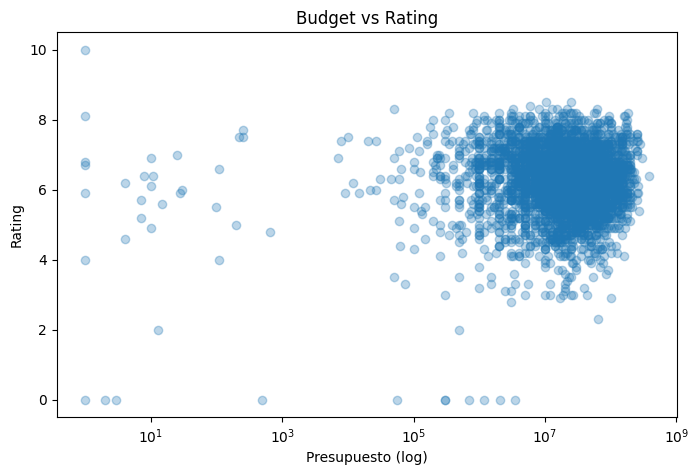

In [7]:

# Análisis de correlación entre presupuesto y rating
df_br = movies[(movies['budget'] > 0) & (movies['vote_average'].notna())]
plt.figure(figsize=(8,5))
plt.scatter(df_br['budget'], df_br['vote_average'], alpha=0.3)
plt.xscale('log')
plt.xlabel('Presupuesto (log)')
plt.ylabel('Rating')
plt.title('Budget vs Rating')
plt.show()


## 5. Eje 3: Evolución de la duración (últimos 50 años)
Analizamos cómo cambió la duración de las películas durante los últimos 50 años.
Se calcula la mediana del runtime por año y se genera una visualización temporal.

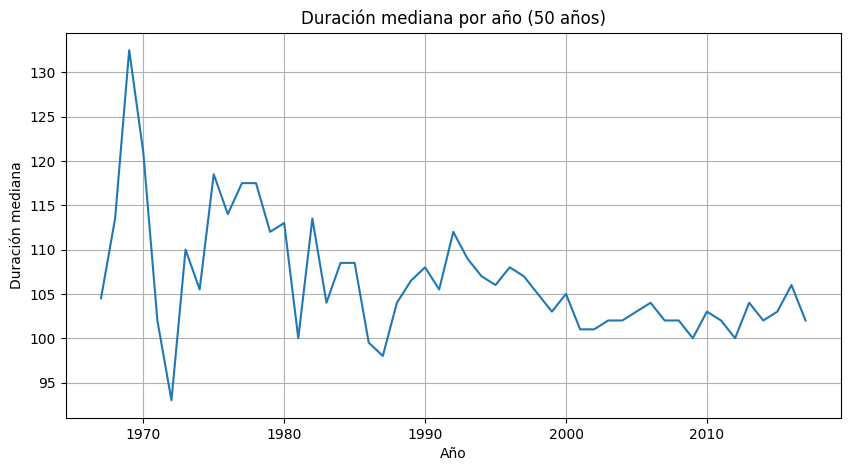

In [8]:
# Duración mediana por año en los últimos 50 años
ultimo_50 = movies[movies['year'] >= (movies['year'].max() - 50)]
duracion = ultimo_50.groupby('year')['runtime'].median()

# Gráfico de duración mediana por año
plt.figure(figsize=(10,5))
plt.plot(duracion.index, duracion.values)
plt.title('Duración mediana por año (50 años)')
plt.xlabel('Año')
plt.ylabel('Duración mediana')
plt.grid()
plt.show()


## 6. Eje 4: Directores con mayor rating promedio
Identificamos al director de cada película, agrupamos su filmografía y calculamos
su rating promedio. Finalmente, obtenemos el top 10 de directores con mejor
promedio y lo graficamos.

In [9]:
# Análisis de directores
def get_director(c):
    try:
        crew = ast.literal_eval(c)
        for p in crew:
            if p.get("job") == "Director":
                return p.get("name")
    except:
        return None

# Agregamos columna de director
df['director'] = df['crew'].apply(get_director)

# Agrupamos por director
directores = (
    df[df['director'].notna()]
      .groupby('director')
      .agg(
          cant=('title_x', 'count'),
          rating=('vote_average', 'mean')
      )
      .reset_index()
      .sort_values('rating', ascending=False)
)

display(directores)

,director,cant,rating
720,Gary Sinyor,1,10.00
1923,Rohit Jugraj,1,9.50
1290,Lance Hool,1,9.30
665,Floyd Mutrux,1,8.50
2178,Tim McCanlies,2,8.45
...,...,...,...
2251,U. Roberto Romano,1,0.00
362,Christopher Scott Cherot,1,0.00
419,Damir Catic,1,0.00
390,Corbin Bernsen,1,0.00


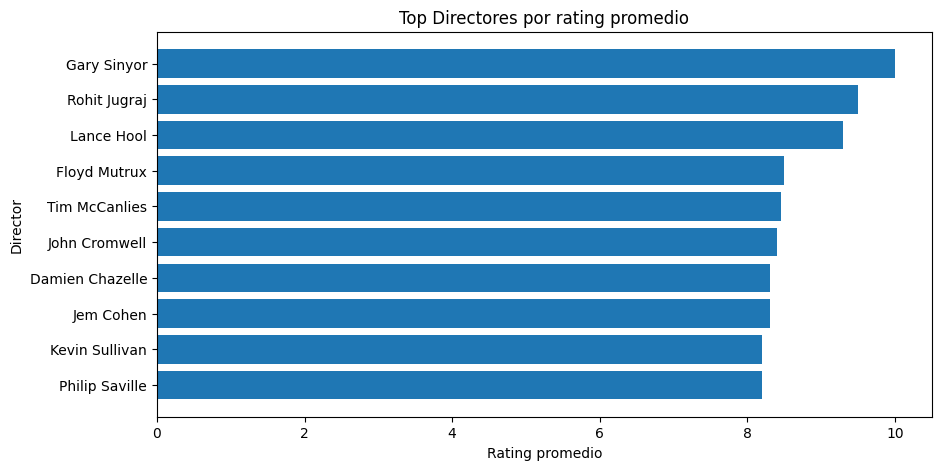

In [10]:
# Gráfico de los 10 directores con mejor rating promedio
top10 = directores.head(10)

# Gráfico
plt.figure(figsize=(10,5))
plt.barh(top10['director'], top10['rating'])
plt.title('Top Directores por rating promedio')
plt.xlabel("Rating promedio")
plt.ylabel("Director")
plt.gca().invert_yaxis()
plt.show()

In [11]:
directores.to_csv('directores_rating.csv', index=False)

## 7. Eje 5: Actores que más aparecen juntos
Extraemos los primeros 5 actores de cada película y contabilizamos las parejas
de actores que aparecen juntos más veces. Se identifican las 10 duplas más
frecuentes y se muestra su gráfico correspondiente.

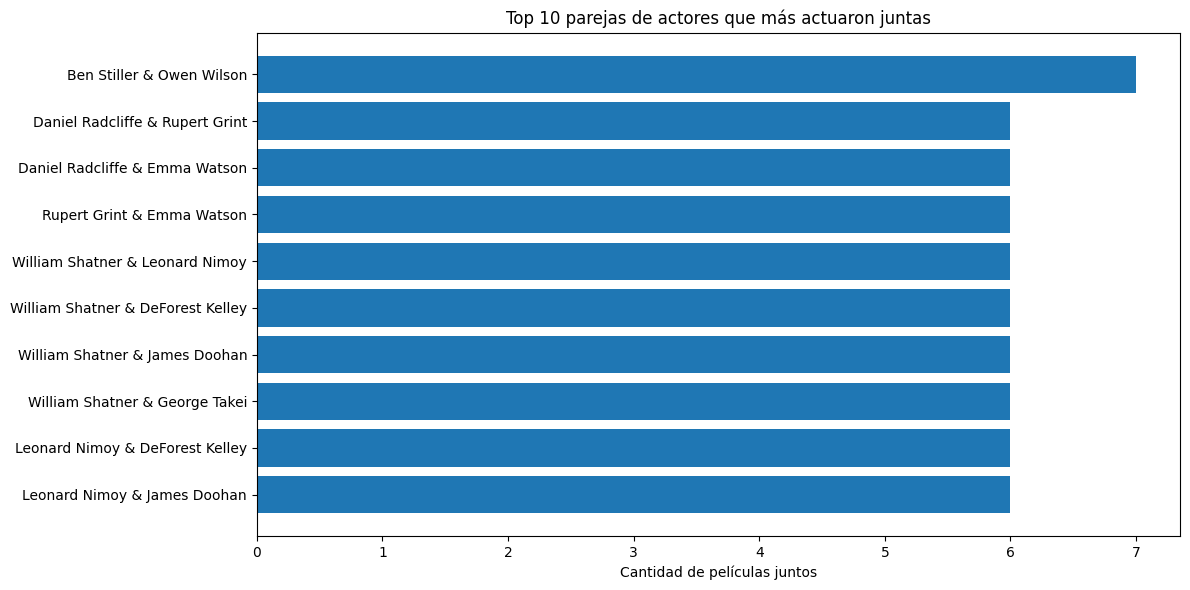

In [12]:
# Análisis de parejas de actores que más actuaron juntos
def get_cast(x):
    try:
        return [p['name'] for p in ast.literal_eval(x)[:5]]
    except:
        return []

# Agregamos columna de elenco
df['cast_list'] = df['cast'].apply(get_cast)

# Contamos parejas
pairs = Counter()
for cast in df['cast_list']:
    for a, b in combinations(cast, 2):
        pairs[(a,b)] += 1

# Obtenemos las 10 parejas más comunes
pairs.most_common()
plt.figure(figsize=(12, 6))
top_pairs = pairs.most_common(10)
pairs_df = pd.DataFrame([
    {"actors": f"{a} & {b}", "count": c}
    for (a, b), c in top_pairs
])
plt.barh(
    pairs_df["actors"],
    pairs_df["count"]
)

# Gráfico
plt.xlabel("Cantidad de películas juntos")
plt.title("Top 10 parejas de actores que más actuaron juntas")
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()



## 8. Eje 6: Distribución del rating por idioma original
Evaluamos el rating promedio según el idioma original de la película.
Para ello traducimos los códigos de idioma y generamos un gráfico comparativo.

In [13]:
# Análisis de rating promedio por idioma original
# Mapeo de códigos de idioma a nombres
language_map = {
    "en": "English",
    "fr": "French",
    "es": "Spanish",
    "de": "German",
    "it": "Italian",
    "pt": "Portuguese",
    "ru": "Russian",
    "ja": "Japanese",
    "ko": "Korean",
    "zh": "Chinese",
    "hi": "Hindi",
    "te": "Telugu",
    "ta": "Tamil",
    "ml": "Malayalam",
    "id": "Indonesian",
    "he": "Hebrew",
    "fa": "Persian",
    "ar": "Arabic",
    "nl": "Dutch",
    "da": "Danish",
    "pl": "Polish",
    "sv": "Swedish",
    "no": "Norwegian",
    "fi": "Finnish",
    "cs": "Czech",
    "el": "Greek",
    "tr": "Turkish",
    "hu": "Hungarian",
    "xx": "Unknown"
}

# Cálculo del rating promedio por idioma original
rating_lang = movies.groupby('original_language')['vote_average'].mean().sort_values(ascending=False)
rating_lang_with_name = rating_lang.rename(index=language_map)
rating_lang_with_name.head(10)


original_language
Telugu        7.500000
Indonesian    7.400000
Hebrew        7.400000
Persian       7.375000
Arabic        7.300000
Dutch         7.175000
Danish        7.128571
Polish        7.100000
Unknown       7.100000
Swedish       7.060000
Name: vote_average, dtype: float64

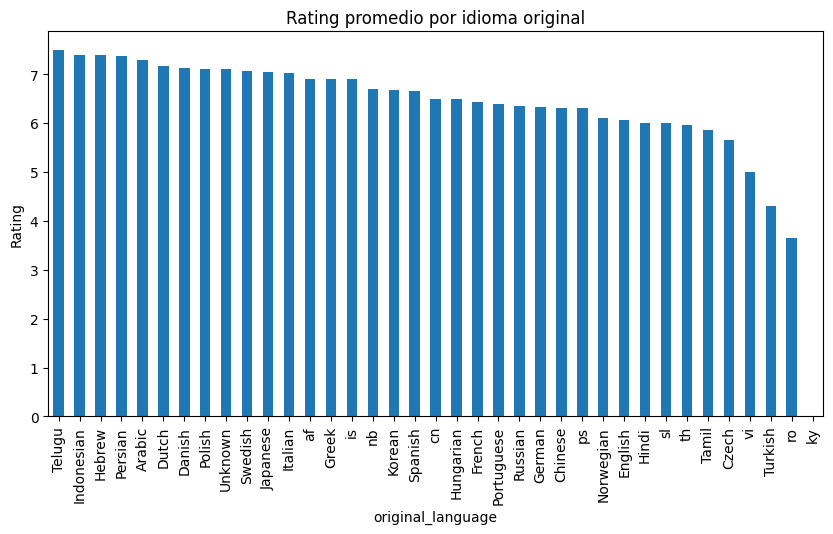

In [14]:
# Gráfico de rating promedio por idioma original
plt.figure(figsize=(10,5))
rating_lang_with_name.plot(kind='bar')
plt.title('Rating promedio por idioma original')
plt.ylabel('Rating')
plt.show()
